## Imports

In [1]:
import collections
import os
import string
import sys
import nltk

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

nltk.download('punkt')

import sys
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
from nltk.tokenize import wordpunct_tokenize
from unidecode import unidecode


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alicemahiant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
data_path = "../data/txt/"

In [3]:
DECADE = '1960'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [4]:
files = [f for f in sorted(os.listdir(data_path)) if f"_{DECADE[:-1]}" in f]

In [5]:
texts = [open(data_path + f).read() for f in files]

## Vectoriser les documents à l'aide de TF-IDF

In [6]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [7]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [8]:
tfidf_vectors = vectorizer.fit_transform(texts)

In [9]:
# Détail de la matrice
tfidf_vectors

<1000x2997 sparse matrix of type '<class 'numpy.float64'>'
	with 591250 stored elements in Compressed Sparse Row format>

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

### Définir un nombre de clusters

In [10]:
N_CLUSTERS = 3

### Instancier le modèle K-Means et ses arguments

In [11]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [12]:
clusters = km_model.fit_predict(tfidf_vectors)

In [13]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [14]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

### Générer le plot

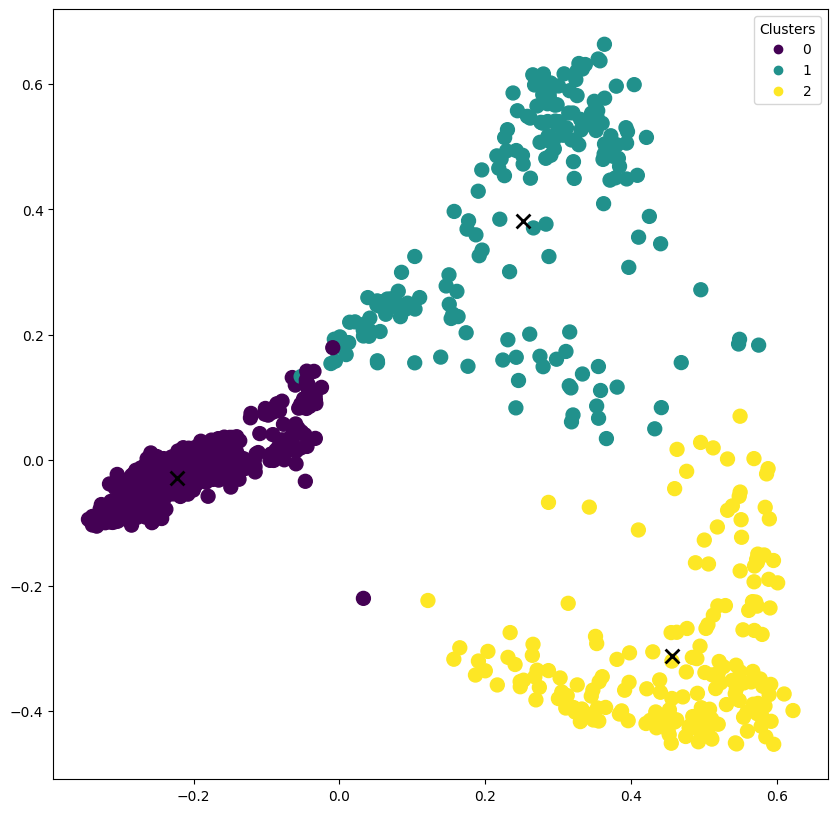

In [15]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")

# Segmentation en phrases

## Fichiers d'inputs et d'outputs

In [ ]:
infile = "../data/txt/all.txt"
outfile = "../data/sents.txt"

In [16]:
class MySentences(object):
    """Tokenize and Lemmatize sentences"""
    def __init__(self, filename):
        self.filename = filename

    def __iter__(self):
        for line in open(self.filename, encoding='utf-8', errors="backslashreplace"):
            yield [unidecode(w.lower()) for w in wordpunct_tokenize(line)]

In [17]:
infile = f"../data/sents.txt"
sentences = MySentences(infile)

In [18]:
bigram_phrases = Phrases(sentences)

In [19]:
type(bigram_phrases.vocab)

dict

In [20]:
len(bigram_phrases.vocab.keys())

15761694